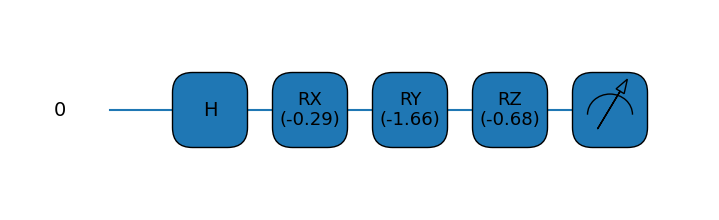

In [11]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from sympy import conjugate
from torch.autograd import Variable
import torch
from rsvg import rsvg
from rdmg import rdm_ginibre
import pennylane as qml
import matplotlib.pyplot as plt

import numpy as np
#def bloch_sphere(circuit):
#    state = Statevector(circuit)
#    return plot_bloch_multivector(state)

#def inner_product(v,w):
#    d = len(v); ip = 0
#    for j in range(0,d):
#        ip += conjugate(v[j])*w[j]
#    return ip

def gen_paulis(d):
    Paulis = Variable(torch.zeros([3*d, 2, 2], dtype=torch.complex128), requires_grad=False)
    aux = 0
    for i in range(0,d,3):
        Paulis[i+aux] = torch.tensor([[0, 1], [1, 0]])        
        Paulis[i+1+aux] = torch.tensor([[0, -1j], [1j, 0]])
        Paulis[i+2+aux] = torch.tensor([[1, 0], [0, -1]])
        aux += 2
    return Paulis

def init_state_fidelity(d):
    target_state = rsvg(d)
    target_op = np.outer(target_state.conj(), target_state)
    target_op = torch.tensor(target_op)
    return target_op

def init_state_exp_val(d):
    rrho = rdm_ginibre(2)
    Paulis = gen_paulis(d)
    target_vector = [np.trace(np.real(np.dot(rrho,i))) for i in Paulis]
    target_vector = Variable(torch.tensor(target_vector ))
    return target_vector


def device_and_random_params(n_qubit):
    device = qml.device('qiskit.aer', wires=n_qubit*3, backend='qasm_simulator')
    params = np.random.normal(0,np.pi/2, n_qubit*3)
    params = Variable(torch.tensor(params), requires_grad=True)
    return device, params

n_qubits = 1
device, params = device_and_random_params(n_qubits)
target_vector = init_state_exp_val(n_qubits)
@qml.qnode(device, interface="torch")
# def circuit(params, M=None):
#     qml.Hadamard(wires=0)
#     qml.RX(params[0], wires=0)
#     qml.RY(params[0], wires=0)
#     qml.RZ(params[0], wires=0)
#     qml.Hadamard(wires=1)
#     qml.RX(params[1], wires=1)
#     qml.RY(params[1], wires=1)
#     qml.RZ(params[1], wires=1)
#     return qml.expval(qml.Hermitian(M, wires=[0,1]))
# drawer = qml.draw(circuit)

def circuit(n_qubits, params, M=None):
    aux=0
    w = []
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.RX(params[i+aux], wires=i)
        qml.RY(params[i+1+aux], wires=i)
        qml.RZ(params[i+2+aux], wires=i)
        w.append(i)
        aux+=2
    #qml.CNOT(wires=[0,1])
    return qml.expval(qml.Hermitian(M, wires=w))
#drawer = qml.draw(circuit)
fig, ax = qml.draw_mpl(circuit, decimals=2)(n_qubits, params,target_vector)
plt.show()


In [12]:
print(type(params))
print(len(params))
print(len(target_vector))
print(len(gen_paulis(2)))
print(np.shape(params))

<class 'torch.Tensor'>
3
3
6
torch.Size([3])


In [8]:
def cost(params, target_vector):
    size = len(params)
    Paulis = gen_paulis(2)
    L = 0
    print(circuit(n_qubits, params, Paulis[0]))# - target_vector[0])
    print(circuit(n_qubits, params, Paulis[1]))# - target_vector[1])
    print(circuit(n_qubits, params, Paulis[2]))# - target_vector[2])
    print(circuit(n_qubits, params, Paulis[0]))# - target_vector[0])
    print(circuit(n_qubits, params, Paulis[1]))# - target_vector[1])
    print(circuit(n_qubits, params, Paulis[2]))# - target_vector[2])
    for k in range(size):
        print(k)
        L += torch.abs(circuit(n_qubits, params, Paulis[k]) - target_vector[k])
    return L
def train(epocas, params, target_vector):
    opt = torch.optim.Adam([params], lr=0.1)
    best_loss = 1*cost(params, target_vector)
    best_params = 1*params
    for epoch in range(epocas):
        opt.zero_grad()
        loss = cost(params, target_vector)
        print(epoch, loss.item())
        loss.backward()
        opt.step()
        if loss < best_loss:
            best_loss = 1*loss
            best_params = 1*params
    return best_params

best_params = train(30, params, target_vector)

ValueError: Input unitary must be of shape (4, 4) or (batch_size, 4, 4) to act on 2 wires.

In [1]:
from multi_pure_prep import init_state_exp_val
from multi_pure_prep import train,gen_paulis
from multi_pure_prep import device_and_random_params
from multi_pure_prep import cost,circuit
import pennylane as qml


ModuleNotFoundError: No module named 'torch'

In [10]:
target_vector = init_state_exp_val(2)
device, params = device_and_random_params()
qc = circuit(params, target_vector)
#qnode = qml.QNode(qc, device=device, interface="torch")
#qnode = qml.QNode(circuit, device=device, interface="torch")
best_params = train(30, params)

TypeError: 'MeasurementProcess' object is not callable

In [ ]:
epochs, fidelity = train(30, circuit, params, cost(params, Paulis, target_vector))

In [ ]:
target_op, params = init_state_params()
best_params, best_loss = train(params,target_op)